# Proyecto Sprint 12

## Preparación de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict

In [2]:
train = pd.read_csv('gold_recovery_train.csv', index_col='date', parse_dates=True)
test = pd.read_csv('gold_recovery_test.csv', index_col='date', parse_dates=True)
full = pd.read_csv('gold_recovery_full.csv', index_col='date', parse_dates=True)

In [3]:
print(train.head())
print()
print(train.info())
print()
print(test.info())
print()
print(full.info())

                     final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   

                     final.output.concentrate_au  final.outp

In [4]:
print(train.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

In [5]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

recovery_calc = (C * (F - T)) / (F * (C - T)) * 100

recovery_real = train['rougher.output.recovery']

valid = recovery_calc.notna() & recovery_real.notna()

mae = np.mean(np.abs(recovery_calc[valid] - recovery_real[valid]))

print(f"Error Absoluto Medio (EAM): {mae:.4f}")

Error Absoluto Medio (EAM): 0.0000


<div class="alert alert-block alert-success">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Muy bien, correcta la comprobación del fórmula, vemos que es muy precisa.

</div>

Error Absoluto Medio (EAM): 0.0000 indica que la fórmula para calcular la recuperación coincide exactamente con los valores reales de recuperación en los datos — no hay discrepancias.

Eso confirma que la columna 'rougher.output.recovery' está correctamente calculada en el conjunto de entrenamiento.

In [6]:
train_cols = set(train.columns)
test_cols = set(test.columns)

missing_in_test = train_cols - test_cols
print("Columnas en 'train' que faltan en 'test':")
for col in sorted(missing_in_test):
    print(col)

Columnas en 'train' que faltan en 'test':
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary

Estas columnas son todas variables objetivo o intermedias, no están disponibles al momento de la predicción, porque son salidas que dependen del resultado del proceso industrial. Las columnas que faltan en test son columnas de salida o cálculos derivados, que no están disponibles para predicción, ya que en un entorno real solo tendría las variables de entrada al momento de hacer la predicción.

Esto es normal y esperado. 

In [7]:
common_columns = train.columns.intersection(test.columns)
train_features = train[common_columns]
test_features = test.copy()
print(common_columns)

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Para construir mi modelo, debo entrenarlo solo con las columnas que están disponibles tanto en train como en test, es decir, las columnas comunes entre ambos.

In [8]:
target_columns = ['rougher.output.recovery', 'final.output.recovery']
train_target = train[target_columns]

Seleccionar variables objetivo

In [9]:
train_full = pd.concat([train_features, train_target], axis=1)

train_full = train_full.dropna()

train_features_clean = train_full[common_columns]
train_target_clean = train_full[target_columns]

Eliminamos filas en train_features y train_target que contengan valores faltantes, para no introducir sesgos o errores.

<div class="alert alert-block alert-success">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Bien hecho, buen uso de `set()` y sus funciones

</div>

## Analisis de Datos

In [10]:
metales = ['au', 'ag', 'pb']
etapas = ['feed', 'concentrate', 'tail']

resultados = {metal.upper(): [] for metal in metales}

for metal in metales:
    for etapa in etapas:
        if etapa == 'feed':
            columna = f'rougher.input.feed_{metal}'
            concentration = train[columna].mean() if columna in train.columns else None
        else:
            columna = f'rougher.output.{etapa}_{metal}'
            concentration = train[columna].mean() if columna in train.columns else None
        
        resultados[metal.upper()].append(concentration)

resultados_df = pd.DataFrame(resultados, index=etapas)

resultados_df

,AU,AG,PB
feed,7.170717,7.832347,3.218931
concentrate,17.401541,10.580475,6.880322
tail,1.763930,5.566579,0.596493


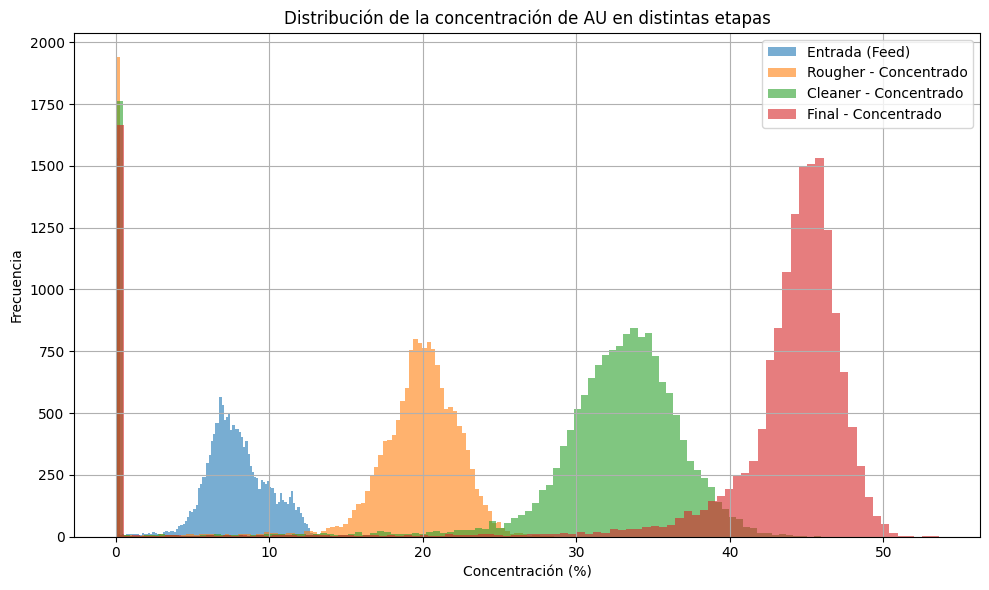

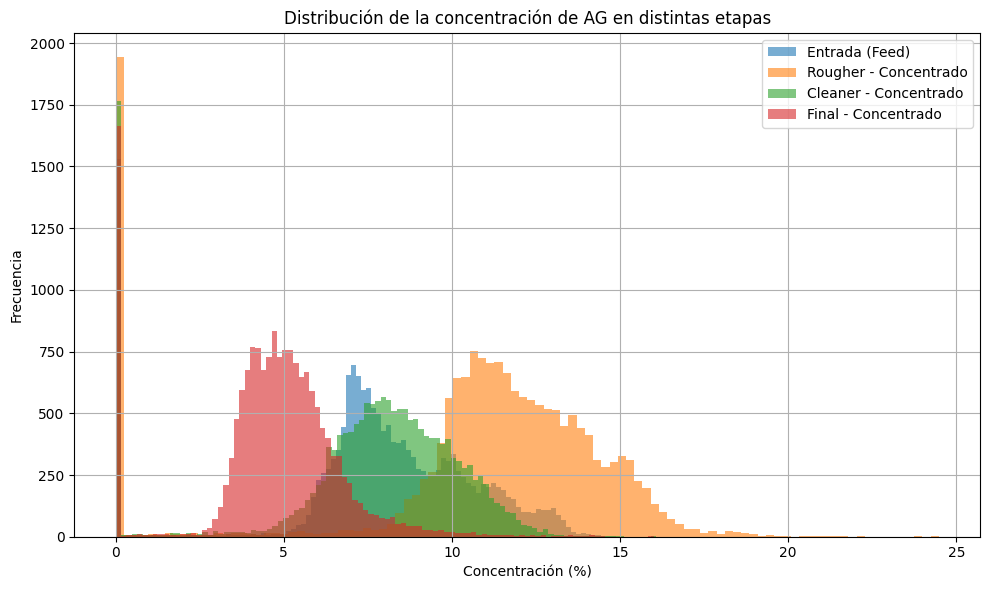

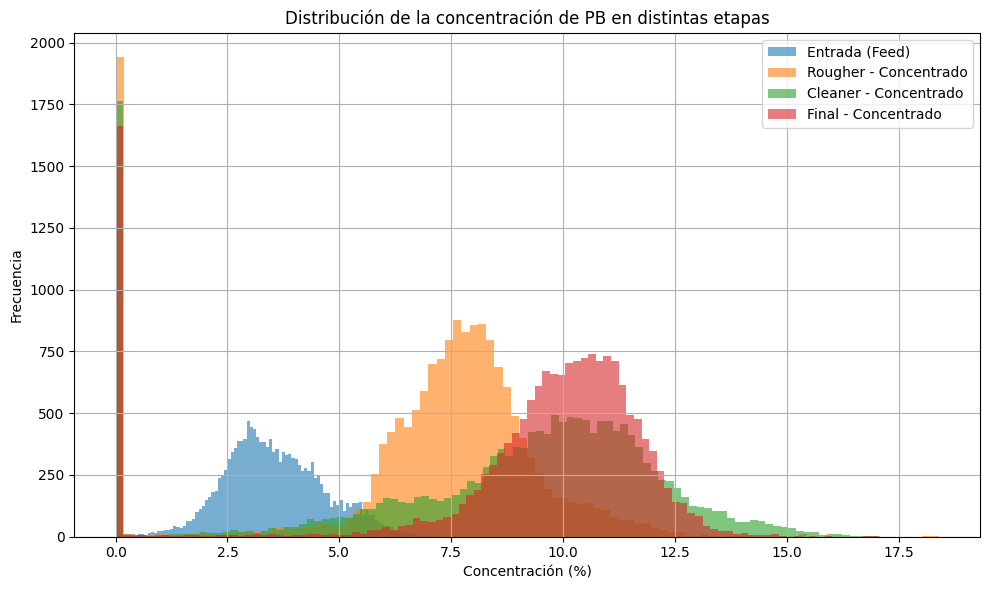

In [11]:
metales = ['au', 'ag', 'pb']

etapas_dict = {
    'rougher.input.feed_{}': 'Entrada (Feed)',
    'rougher.output.concentrate_{}': 'Rougher - Concentrado',
    'primary_cleaner.output.concentrate_{}': 'Cleaner - Concentrado',
    'final.output.concentrate_{}': 'Final - Concentrado'
}

for metal in metales:
    plt.figure(figsize=(10, 6))

    for plantilla_col, nombre_etapa in etapas_dict.items():
        columna = plantilla_col.format(metal)
        if columna in train.columns:
            train[columna].hist(bins=100, alpha=0.6, label=nombre_etapa)

    plt.title(f'Distribución de la concentración de {metal.upper()} en distintas etapas')
    plt.xlabel('Concentración (%)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

El proceso de purificación parece ser eficaz para concentrar los metales de interés (Au, Ag, Pb) en la etapa de concentrado, aumentando sus concentraciones en comparación con la etapa feed. Al mismo tiempo, la etapa tail muestra una reducción significativa en las concentraciones, lo que indica la remoción de los metales no deseados.

<div class="alert alert-block alert-danger">
<b>Comentario de Reviewer </b> <a class="tocSkip"></a>

Ok con la tabla para mostrar la concentración media, pero queda un poco corto para lo que se quiere mostrar. En esta parte debes graficar el cambio de la distribución de la concentración de cada uno de los metales. Realiza un gráfico para cada metal (au, ag, pb) donde en el mismo gráfico estén 4 histogramas, uno para cada uno de los siguientes rougher.input.feed_{}, rougher.output.concentrate_{}, primary_cleaner.output.concentrate_{} y final.output.concentrate_{} ({} reemplazalo para cada metal).
</div>

<div class="alert alert-block alert-success">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Bien hecho, podemos apreciar claramente como los procesos realizados aumentan la concentración del oro, mientras que los otros metales experimentan bajas o variaciones menores.

</div>

In [12]:
train_column_exists = 'rougher.input.feed_size' in train.columns
test_column_exists = 'rougher.input.feed_size' in test.columns

print(f"Columna 'rougher.input.feed_size' en entrenamiento: {train_column_exists}")
print(f"Columna 'rougher.input.feed_size' en prueba: {test_column_exists}")

Columna 'rougher.input.feed_size' en entrenamiento: True
Columna 'rougher.input.feed_size' en prueba: True


Verificar si la columna rougher.input.feed_size está presente en los dos conjuntos de datos.

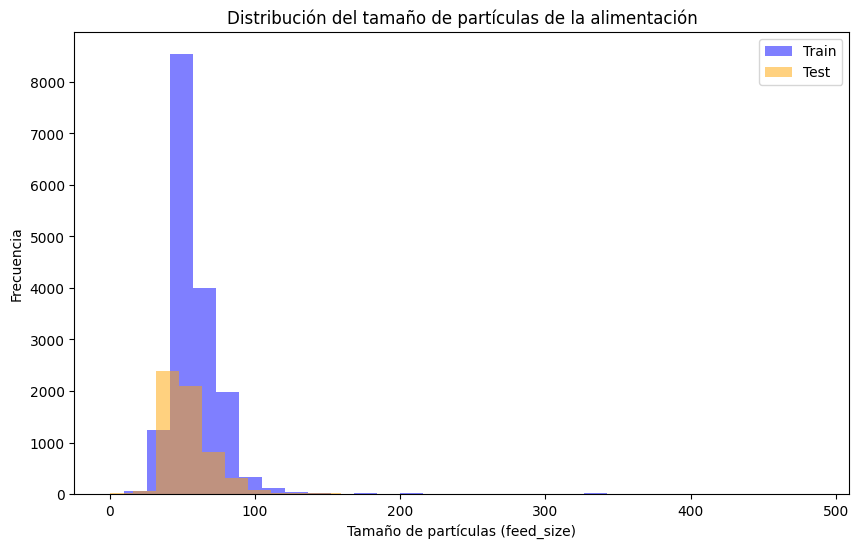

In [13]:
plt.figure(figsize=(10, 6))

plt.hist(train['rougher.input.feed_size'].dropna(), bins=30, alpha=0.5, label='Train', color='blue')

plt.hist(test['rougher.input.feed_size'].dropna(), bins=30, alpha=0.5, label='Test', color='orange')

plt.xlabel('Tamaño de partículas (feed_size)')
plt.ylabel('Frecuencia')
plt.title('Distribución del tamaño de partículas de la alimentación')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Muy bien, correcta la comparación entre las dos distribuciones. Si bien podemos hacer test estadísticos para ver que tan similares son, al menos desde un punto de vista del gráfico, sí se ven similares.

</div>

In [14]:
train_feed_size_stats = train['rougher.input.feed_size'].describe()
test_feed_size_stats = test['rougher.input.feed_size'].describe()

comparison_df = pd.DataFrame({
    'Entrenamiento': train_feed_size_stats,
    'Prueba': test_feed_size_stats
})

print(comparison_df)

       Entrenamiento       Prueba
count   16443.000000  5834.000000
mean       58.676444    55.937535
std        23.922591    22.724254
min         9.659576     0.046369
25%        47.575879    43.890852
50%        54.104257    50.002004
75%        65.051064    61.638434
max       484.967466   477.445473


El análisis muestra que los tamaños de partículas alimentadas en el proceso de flotación son bastante similares entre los conjuntos de entrenamiento y prueba en términos de tendencia central (media y mediana), pero existe una discrepancia significativa en los valores mínimos, especialmente en el conjunto de prueba, donde se observan valores extremadamente bajos que podrían necesitar revisión o limpieza de datos.

In [15]:
umbral_min = train['rougher.input.feed_size'].quantile(0.01)
test_clean = test[test['rougher.input.feed_size'] >= umbral_min]

print(test_clean['rougher.input.feed_size'].describe())

count    5776.000000
mean       56.288542
std        22.551669
min        28.611681
25%        43.993854
50%        50.357200
75%        61.840399
max       477.445473
Name: rougher.input.feed_size, dtype: float64


<div class="alert alert-block alert-success">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Muy bien, correcta la eliminación de outliers

</div>

In [16]:
train_feed_size_stats = train['rougher.input.feed_size'].describe()
test_feed_size_stats = test_clean['rougher.input.feed_size'].describe()

comparison_df = pd.DataFrame({
    'Entrenamiento': train_feed_size_stats,
    'Prueba': test_feed_size_stats
})

print(comparison_df)

       Entrenamiento       Prueba
count   16443.000000  5776.000000
mean       58.676444    56.288542
std        23.922591    22.551669
min         9.659576    28.611681
25%        47.575879    43.993854
50%        54.104257    50.357200
75%        65.051064    61.840399
max       484.967466   477.445473


El valor mínimo atípico en prueba podría ser legítimo, considerando que las demás métricas están alineadas entre entrenamiento y prueba. El hecho de que tras limpiar los datos el valor mínimo ahora es mas alto sugiere que, en realidad, ese valor bajo original podría formar parte de la variabilidad natural del proceso, y no necesariamente representa un error. Por lo tanto, el resultado original podría ser correcto, y no sería necesario hacer más limpieza o eliminarlo si no hay una justificación técnica para hacerlo.

In [17]:
metales = ['au', 'ag', 'pb']
etapas = ['materia_prima', 'concentrado_rougher', 'concentrado_final']

concentraciones_totales = {etapa: [] for etapa in etapas}

for etapa in etapas:
    for metal in metales:
        if etapa == 'materia_prima':
            columna = f'rougher.input.feed_{metal}'
        elif etapa == 'concentrado_rougher':
            columna = f'rougher.output.concentrate_{metal}'
        else: 
            columna = f'final.output.concentrate_{metal}'
        
        if columna in train.columns:
            concentracion_media = train[columna].mean()
        else:
            concentracion_media = None
        
        concentraciones_totales[etapa].append(concentracion_media)

concentraciones_df = pd.DataFrame(concentraciones_totales, index=metales)

print(concentraciones_df)

    materia_prima  concentrado_rougher  concentrado_final
au       7.170717            17.401541          39.467217
ag       7.832347            10.580475           4.716907
pb       3.218931             6.880322           9.113559


In [18]:
componentes = ['au', 'ag', 'pb', 'sol']

concentraciones_totales_etapas = {}

for etapa in ['feed', 'concentrate']:
    columnas = [f'rougher.input.feed_{c}' if etapa == 'feed' else f'rougher.output.concentrate_{c}' for c in componentes]
    columnas_presentes = [col for col in columnas if col in train.columns]
    concentraciones_totales_etapas[f'rougher_{etapa}'] = train[columnas_presentes].sum(axis=1)

columnas_final = [f'final.output.concentrate_{c}' for c in componentes]
columnas_final_presentes = [col for col in columnas_final if col in train.columns]
concentraciones_totales_etapas['final_concentrate'] = train[columnas_final_presentes].sum(axis=1)

Los resultados parecen ser relativamente consistentes con lo esperado, pero hay algunas observaciones importantes que debemos tener en cuenta:El concentrado final tiene una concentración de plata más baja (4.72 g/t). 

La caída de la plata (Ag) de 10.58 a 4.72 parece estar dentro de lo razonable dado el contexto de un proceso de flotación y purificación. En tales procesos industriales, es común que algunos metales secundarios (como la plata) se pierdan en la etapa de purificación, mientras que otros (como el oro) son más concentrados y retenidos en el concentrado final.

Por lo tanto, no hay indicios de que este cambio sea anómalo, y no parece necesario realizar ninguna eliminación de valores o ajuste en los datos de plata (Ag). La caída puede considerarse un comportamiento esperado del proceso, y no hay motivos claros para eliminar estos valores.

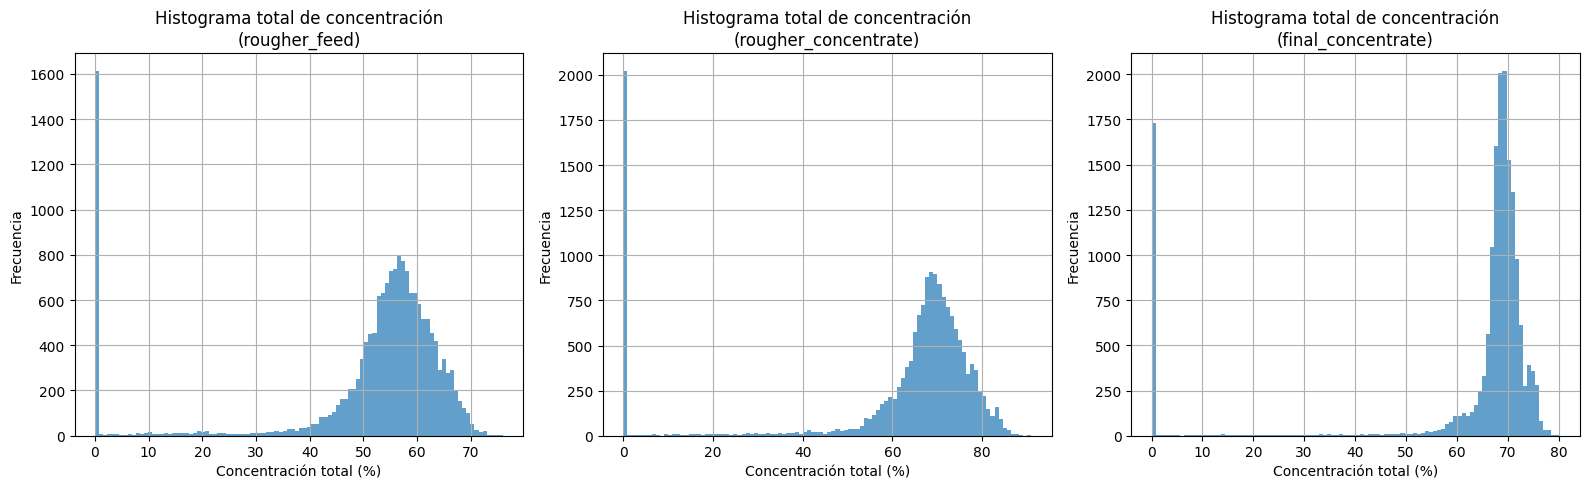

In [19]:
plt.figure(figsize=(16, 5))

for i, (etapa, datos) in enumerate(concentraciones_totales_etapas.items(), 1):
    plt.subplot(1, 3, i)
    datos.hist(bins=100, alpha=0.7)
    plt.title(f'Histograma total de concentración\n({etapa})')
    plt.xlabel('Concentración total (%)')
    plt.ylabel('Frecuencia')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
umbral_minimo = 10 

filtros = []
for etapa, serie in concentraciones_totales_etapas.items():
    filtros.append(serie > umbral_minimo)

filtro_final = filtros[0]
for f in filtros[1:]:
    filtro_final &= f

train_limpio = train[filtro_final].copy()

print(f"Filas antes de la limpieza: {train.shape[0]}")
print(f"Filas después de la limpieza: {train_limpio.shape[0]}")

Filas antes de la limpieza: 16860
Filas después de la limpieza: 14513


<div class="alert alert-block alert-success">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Bien con el cálculo de la media para estas variables desglosado por metal. Constatamos algo similar a lo observado anteriormente, como el proceso completo aumenta la concentración del oro principalmente.

</div>

<div class="alert alert-block alert-danger">
<b>Comentario de Reviewer </b> <a class="tocSkip"></a>

De forma adicional quisieramos ver los outliers y revisar las distribuciones importantes. Grafica un histograma para el total de la concentración de cada etapa (para de cada etapa rougher.input.feed_{}, rougher.output.concentrate_{} y final.output.concentrate_{}, suma au, ag, pb y sol, serán 3 gráficos, uno para cada etapa). En base a esto, verás de forma más clara donde hay outliers. Revisa cómo removerlos antes de pasar a la parte del modelo.
</div>

<div class="alert alert-block alert-success">
<b>Comentario de Revisor v2</b> <a class="tocSkip"></a>

Excelente, muy bien con la identificación y eliminación de outliers.

</div>

## Construcción del modelo

In [21]:
train_limpio_filtrado = train_limpio.dropna(subset=target_columns)

train_target_clean = train_limpio_filtrado[target_columns]
train_features_clean = train_limpio_filtrado.drop(columns=target_columns)

train_features_clean = train_features_clean.select_dtypes(include=[np.number])

train_features_clean = train_features_clean.replace([np.inf, -np.inf], np.nan)
valid_index = train_features_clean.dropna().index

train_features_clean = train_features_clean.loc[valid_index]
train_target_clean = train_target_clean.loc[valid_index]

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    return np.mean(diff / denominator) * 100

In [22]:
model = LinearRegression()

rougher_preds = cross_val_predict(model, train_features_clean, train_target_clean['rougher.output.recovery'], cv=5)
smape_rougher = smape(train_target_clean['rougher.output.recovery'], rougher_preds)

final_preds = cross_val_predict(model, train_features_clean, train_target_clean['final.output.recovery'], cv=5)
smape_final = smape(train_target_clean['final.output.recovery'], final_preds)

smape_total = 0.25 * smape_rougher + 0.75 * smape_final

print("LinearRegression:")
print(f"  sMAPE Rougher: {smape_rougher:.4f}")
print(f"  sMAPE Final: {smape_final:.4f}")
print(f"  sMAPE Total: {smape_total:.4f}\n")

LinearRegression:
  sMAPE Rougher: 2.8550
  sMAPE Final: 2.5013
  sMAPE Total: 2.5898



In [23]:
param_grid = [
    {'n_estimators': 50, 'max_depth': 5},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 200, 'max_depth': 15},
    {'n_estimators': 300, 'max_depth': 20},
    {'n_estimators': 100, 'max_depth': None},
]

print("Random Forest:\n")
for params in param_grid:
    model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        random_state=42,
        n_jobs=-1
    )

    rougher_preds = cross_val_predict(model, train_features_clean, train_target_clean['rougher.output.recovery'], cv=5)
    smape_rougher = smape(train_target_clean['rougher.output.recovery'], rougher_preds)

    final_preds = cross_val_predict(model, train_features_clean, train_target_clean['final.output.recovery'], cv=5)
    smape_final = smape(train_target_clean['final.output.recovery'], final_preds)

    smape_total = 0.25 * smape_rougher + 0.75 * smape_final

    print(f"RandomForest (n_estimators={params['n_estimators']}, max_depth={params['max_depth']})")
    print(f"  sMAPE Rougher: {smape_rougher:.4f}")
    print(f"  sMAPE Final: {smape_final:.4f}")
    print(f"  sMAPE Total: {smape_total:.4f}\n")

Random Forest:

RandomForest (n_estimators=50, max_depth=5)
  sMAPE Rougher: 2.4977
  sMAPE Final: 4.4208
  sMAPE Total: 3.9401

RandomForest (n_estimators=100, max_depth=10)
  sMAPE Rougher: 1.1655
  sMAPE Final: 1.6555
  sMAPE Total: 1.5330

RandomForest (n_estimators=200, max_depth=15)
  sMAPE Rougher: 1.1093
  sMAPE Final: 1.4503
  sMAPE Total: 1.3650

RandomForest (n_estimators=300, max_depth=20)
  sMAPE Rougher: 1.1056
  sMAPE Final: 1.4566
  sMAPE Total: 1.3688

RandomForest (n_estimators=100, max_depth=None)
  sMAPE Rougher: 1.1013
  sMAPE Final: 1.4689
  sMAPE Total: 1.3770



### Comparación de Modelos: Random Forest vs. Regresión Lineal

El modelo **Random Forest** con parámetros `n_estimators=200` y `max_depth=15` tuvo un desempeño significativamente superior al modelo de **Regresión Lineal** en términos de **sMAPE Total**, que es la métrica clave de evaluación en este caso.

| Modelo           | sMAPE Rougher | sMAPE Final | sMAPE Total |
|------------------|---------------|-------------|--------------|
| Random Forest    | **1.1093**     | **1.4503**   | **1.3650**    |
| LinearRegression | 2.8550        | 2.5013      | 2.5898       |



El modelo Random Forest supera claramente a la Regresión Lineal debido a su capacidad para capturar relaciones no lineales y complejas entre las variables. Mientras que la Regresión Lineal asume una relación lineal entre las variables predictoras y la variable objetivo, Random Forest utiliza múltiples árboles de decisión y puede manejar interacciones entre características, así como la presencia de ruido en los datos, lo que lo hace más robusto y preciso en este contexto.


<div class="alert alert-block alert-success">
<b>Comentario de Reviewer </b> <a class="tocSkip"></a>

Correcto, muy bien en esta parte al entrengar diferentes modelos y usar la métrica de smape.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Además de probar con una versión por defecto de los modelos, entrena versiones con diferentes parámetros. Por ejemplo, para random forest podrías variar n_estimators y depth, de forma de ver el efecto de estos parámetros en el desempeño del modelo.

</div>

<div class="alert alert-block alert-success">
<b>Comentario de Revisor v2</b> <a class="tocSkip"></a>

Buen trabajo! Muy bien al probar los diferentes modelos 

</div>